In [ ]:
#Questions

#Q1
#Do we include correlations between target variables? or just between features and target variables?

#Q2
#Do we do this for all numerical features? That's a ton of histograms

#Q3

In [1]:
#Q1a


#Targets: suicide_no and suicide/100k

#number of suicides highly correlated with population. For a fixed suicide rate, a higher population will result in a higher number of suicides
#suicide rate slightly correlated with number of suicides. suicide_rate = suicide_no/pop. Strength of the correlation depends on pop


#Q2a

import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

suic_df = pd.read_csv("archive/master.csv")
suic_profile = ProfileReport(suic_df, title="Suicide Profiling Report")
suic_profile.to_widgets()

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
#Q1b

#Targets: casual, registered, cnt

#High correlation between registered and cnt. This implies that most users are registered 
#Medium negative correlation between "workingday" and casual. Workingday is 1 if the day is a holiday/weekend, 0 o.w.
    #Implies that casual users tend to do most of their biking during the weekened/holidays - makes sense
    #since they're probably doing it as a chill activity, rather than a daily workout or a means to get to work/school

#All three have medium-high correlations with temp/atemp. People like biking in warmer weather
#Registered/cnt have medium-high correlations with year - most registered bikers were biking in 2012.
    # could imply that people have been using rental bikes more in more, so there were just more users in 2012 than 2011.

bike_df = pd.read_csv("Bike-Sharing-Dataset/day.csv")
bike_profile = ProfileReport(bike_df, title="Bike Sharing Profiling Report")
bike_profile.to_widgets()

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
#Q1c

#Target variables: utime (transcoding time)

#Transcoding time high correlated with total codec allocated memory for transcoding, and medium-high correlation
#transcoding width/height. It takes longer to transcode larger sequences, which also means that it takes more memory to
#transcode the sequence



vid_df = pd.read_csv("online_video_dataset/transcoding_mesurment.tsv", delimiter='\t')
vid_profile = ProfileReport(vid_df, title="Video Transcoding Profiling Report")
vid_profile.to_widgets()

Summarize dataset:   0%|          | 0/35 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#Q4 
import matplotlib.pyplot as plt
trunc_bike_df = bike_df.truncate(before=220,after=310)
trunc_bike_df.plot(kind='bar',x='dteday',y='cnt', 
                   title='Count Number per Day',xlabel ='Date',
                  ylabel = 'Count',figsize = (18,6), legend = False)

plt.show()

#I picked some random indexes into the graph - not sure is this is the best one
#Looks like ridership goes way down on weekends, esp. Saturdays

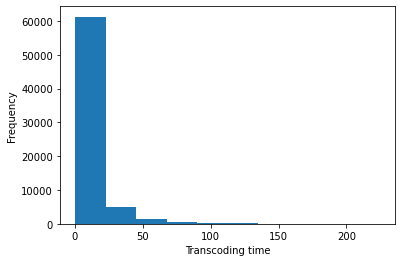

Mean: 9.996354820888579 s
Median: 4.408 s


In [18]:
#Q6
import matplotlib.pyplot as plt


#Most transcodings take very little time: between 0s and 10s

utime_vals = vid_df['utime'].to_numpy()
plt.hist(utime_vals)
plt.xlabel("Transcoding time")
plt.ylabel("Frequency")
plt.show()

print("Mean: {} s".format(np.mean(utime_vals)))
print("Median: {} s".format(np.median(utime_vals)))